In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import data from cleaning stage.
df=pd.read_csv('DataCleaning/train.csv')


In [4]:
#First look at the data.
df.describe()

,subject_id,hadm_id,stay_id,admission_age,temperature,heartrate,resprate,o2sat,sbp,dbp,...,cc_90,cc_91,cc_92,cc_93,cc_94,cc_95,cc_96,cc_97,cc_98,cc_99
count,3.689750e+05,1.807550e+05,3.689750e+05,368907.000000,348258.000000,353887.000000,53849.000000,350719.000000,352851.000000,352079.000000,...,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000,368975.000000
mean,1.500655e+07,2.499402e+07,3.499836e+07,53.071986,98.087508,85.030514,21.396665,98.390677,135.018383,77.401107,...,-0.000037,-0.000096,0.000055,-0.000085,0.000040,0.000165,-0.000033,0.000015,-0.000017,-0.000065
std,2.879691e+06,2.889350e+06,2.889052e+06,20.618742,0.979087,17.726015,3.214972,2.075753,22.373196,14.771998,...,0.130970,0.130290,0.129666,0.127676,0.126682,0.125511,0.124345,0.122533,0.121487,0.121251
min,1.000003e+07,2.000002e+07,3.000001e+07,18.000000,82.400000,1.000000,20.000000,42.000000,50.000000,20.000000,...,-1.169498,-0.809954,-0.860438,-0.990663,-1.051793,-0.991421,-0.920276,-1.335590,-0.860081,-0.947645
25%,1.251484e+07,2.248954e+07,3.249924e+07,35.000000,97.520000,72.000000,20.000000,97.000000,120.000000,68.000000,...,-0.065882,-0.069550,-0.081095,-0.067329,-0.067872,-0.059232,-0.070111,-0.069883,-0.052943,-0.057060
50%,1.500900e+07,2.499661e+07,3.499366e+07,54.000000,98.000000,84.000000,20.000000,99.000000,133.000000,77.000000,...,-0.004975,0.006199,-0.001144,-0.006876,0.000492,-0.004185,0.004632,0.010340,-0.006824,0.000271
75%,1.750052e+07,2.749140e+07,3.750745e+07,69.000000,98.600000,96.000000,22.000000,100.000000,148.000000,87.000000,...,0.063387,0.076588,0.071376,0.065216,0.067230,0.061849,0.073439,0.055719,0.055409,0.061214
max,1.999999e+07,2.999981e+07,3.999996e+07,91.000000,110.000000,256.000000,100.000000,100.000000,299.000000,199.000000,...,1.013891,1.113066,1.224873,1.032952,1.258595,1.175944,0.782158,0.953618,0.805279,0.772841


Below we consider relationships between individual predictor variables and the target variable, stay length. In general, we found little to no relationship between any individual predictor variables and the target variable. In some cases, there was some relatiohship apparent, but it was swamped by the overall variation in the data.


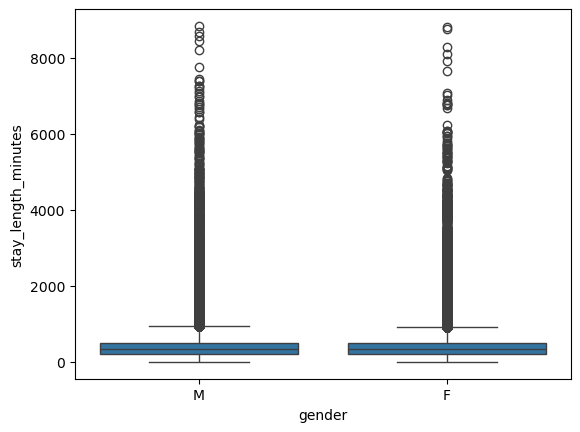

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,200350.0,435.522342,382.712355,1.0,222.0,336.0,503.0,8798.0
M,168625.0,434.760190,405.431080,1.0,211.0,328.0,505.0,8839.0


In [40]:
#Looking at stay length, grouped by gender.  These distributions appear very similar. 
# There appears no direct relationship between gender and stay length.

sns.boxplot(x='gender',y='stay_length_minutes', data=df)
plt.savefig('gender_stay_length.png', dpi=300) 
plt.show()
df.groupby('gender')['stay_length_minutes'].describe()

In [26]:
#Looking at stay length, grouped by race. There does seem to be substantial variation across racial categories, 
# but it does not line up nicely with the hierarchy of the categories. For example, note that stay lengths are shorter, generally for "Hispanic or Latino" 
#compareed to the various 'Hispanic/Latino' subcategories.

df.groupby('race')['stay_length_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,897.0,478.095336,483.651624,3.00,231.000000,344.000000,529.0000,4915.00
ASIAN,6378.0,386.217325,370.909541,5.00,187.000000,292.000000,441.0000,6895.00
ASIAN - ASIAN INDIAN,1382.0,397.464653,352.359153,6.00,197.000000,308.000000,466.0000,3537.00
ASIAN - CHINESE,6439.0,414.037032,351.153549,1.00,213.000000,324.000000,487.0000,4535.00
ASIAN - KOREAN,694.0,369.004995,319.292472,4.00,183.000000,291.500000,454.2500,3766.00
ASIAN - SOUTH EAST ASIAN,1351.0,427.946237,349.261641,7.00,223.000000,326.000000,504.5000,3154.00
BLACK/AFRICAN,4182.0,432.617862,404.842237,3.00,206.000000,318.000000,503.0000,7032.00
BLACK/AFRICAN AMERICAN,66044.0,445.337762,416.228043,1.00,216.000000,335.000000,516.0000,8746.00
BLACK/CAPE VERDEAN,6683.0,391.840880,317.362227,7.00,209.000000,314.000000,462.0000,4623.00


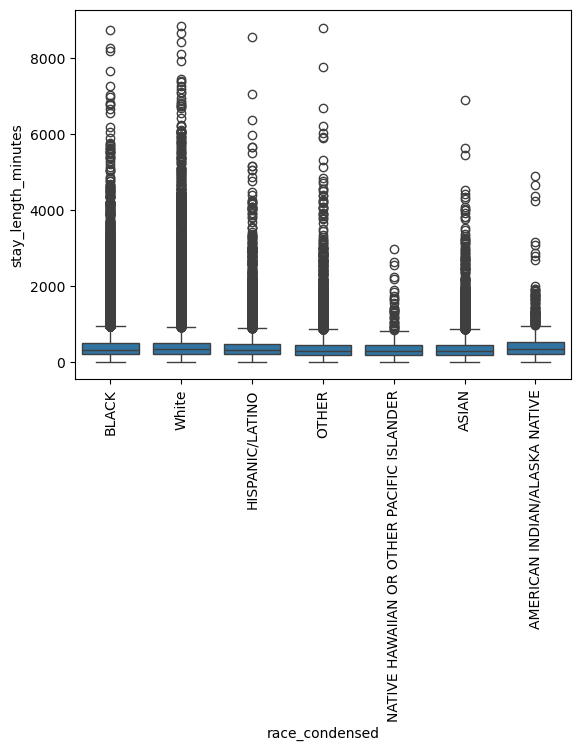

,count,mean,std,min,25%,50%,75%,max
race_condensed,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,897.0,478.095336,483.651624,3.0,231.000000,344.0,529.0,4915.0
ASIAN,16244.0,400.936933,358.033383,1.0,200.000000,310.0,468.0,6895.0
BLACK,80128.0,440.278819,406.385141,1.0,216.000000,333.0,512.0,8746.0
HISPANIC/LATINO,29934.0,423.932899,372.556721,2.0,216.000000,328.0,494.0,8566.0
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,439.0,416.281283,384.968568,2.0,202.391667,303.0,462.5,2989.0
OTHER,20560.0,407.889683,383.391319,2.0,203.000000,312.0,470.0,8798.0
White,214886.0,444.830344,395.880390,1.0,224.000000,341.0,512.0,8839.0


In [45]:
#As provided, the data on race has many different categories. 
#To make this manageable, we condenses categories using the standard US Census categories.
#There is some variable across categories, but considerable variation within categories.

sns.boxplot(x='race_condensed',y='stay_length_minutes', data=df)
plt.xticks(rotation=90)
plt.show()

df.groupby('race_condensed')['stay_length_minutes'].describe()


,count,mean,std,min,25%,50%,75%,max
arrival_transport,,,,,,,,
AMBULANCE,137430.0,501.896457,440.511408,1.000000,257.0,381.0,577.0,8839.0
HELICOPTER,782.0,287.654369,226.483883,12.000000,155.0,232.5,339.0,1782.0
OTHER,1111.0,474.920297,505.168402,25.033333,200.0,329.0,510.5,5732.0
UNKNOWN,8345.0,226.246267,199.799470,1.000000,106.0,193.0,299.0,4746.0
WALK IN,221307.0,401.939844,358.851375,1.000000,202.0,310.0,467.0,8200.0


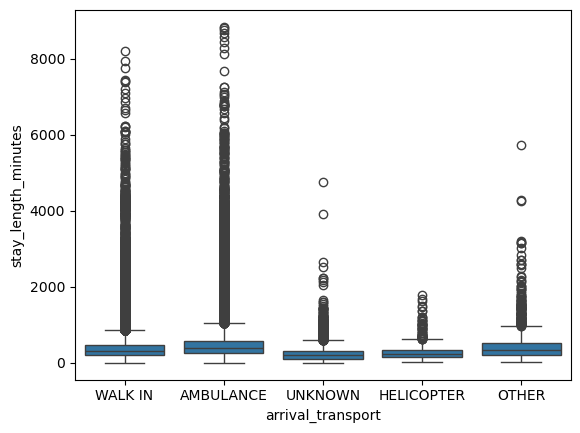

In [14]:
#Looking at stay length, grouped by arrival transport. There are more significant differences between categories here, 
#but still considerable variation within categories.

sns.boxplot(x='arrival_transport',y='stay_length_minutes', data=df)
df.groupby('arrival_transport')['stay_length_minutes'].describe()

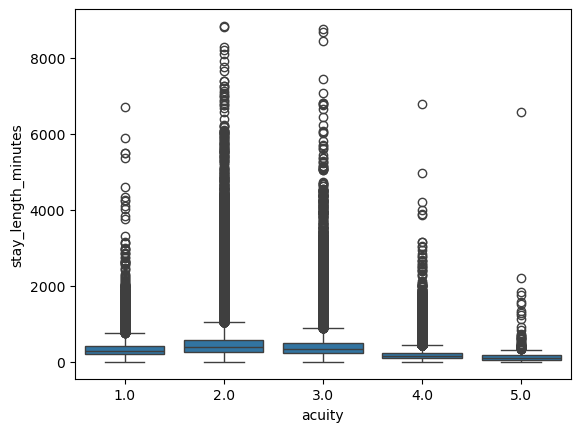

,count,mean,std,min,25%,50%,75%,max
acuity,,,,,,,,
1.0,21376.0,366.224087,297.437277,1.0,201.0,294.133333,430.154167,6700.0
2.0,122115.0,519.438167,469.679559,1.0,263.0,385.000000,582.000000,8839.0
3.0,194060.0,424.152900,352.519512,3.0,223.0,333.950000,496.000000,8746.0
4.0,24349.0,211.670325,211.067162,3.0,112.0,165.000000,242.000000,6781.0
5.0,877.0,155.329342,283.307995,3.0,61.0,113.000000,170.000000,6564.0


In [41]:
#Acuity is a ranking by a registered nurse based on the Emergency Severity Index (ESI). See details here: https://mimic.mit.edu/docs/iv/modules/ed/triage/ 
#The relationship we see here matches intuition: the most extreme cases (either most severe or least severe) 
#have the shortest stays in the ED on avrage. However, as we've seen with other variables, there is considerable variation within categories.
sns.boxplot(x='acuity',y='stay_length_minutes', data=df)
plt.savefig('acuity_stay_length.png', dpi=300) 
plt.show()
df.groupby('acuity')['stay_length_minutes'].describe()

<Axes: xlabel='pain_cleaned_advanced', ylabel='stay_length_minutes'>

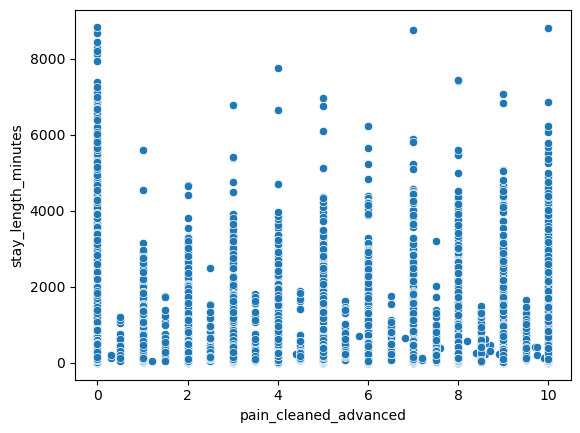

In [31]:
#A look at stay length vs pain rating. There is no pattern here.

sns.scatterplot(x="pain_cleaned_advanced",
                    y="stay_length_minutes",
                    data=df)

<Axes: xlabel='temperature', ylabel='stay_length_minutes'>

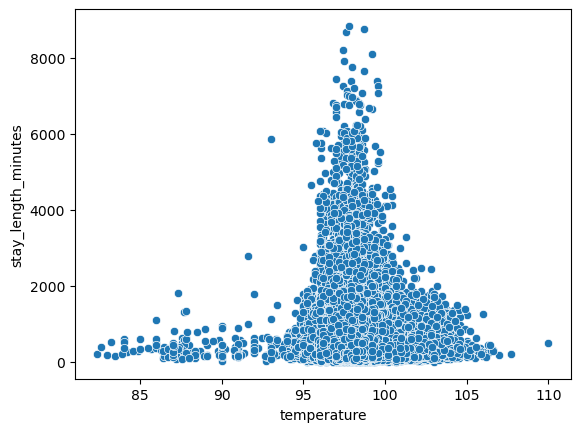

In [17]:
#A look at stay length vs temperature. The longest stay lengths occur at temperatures between 95 and 100. 
# Given that most of the temperature data are in this range, this is what we would expect if there was no relationship.

sns.scatterplot(x="temperature",
                    y="stay_length_minutes",
                    data=df)

<Axes: xlabel='heartrate', ylabel='stay_length_minutes'>

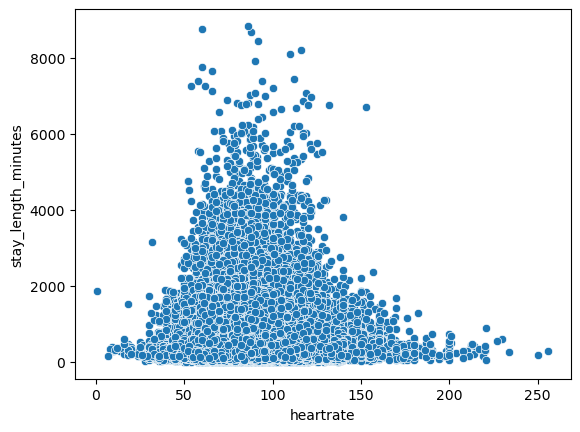

In [35]:
#A look at stay length vs heart rate. Again, the high stay lengths seem to just be falling in the range of the most common values. 
sns.scatterplot(x="heartrate",
                    y="stay_length_minutes",
                    data=df)

<Axes: xlabel='resprate', ylabel='stay_length_minutes'>

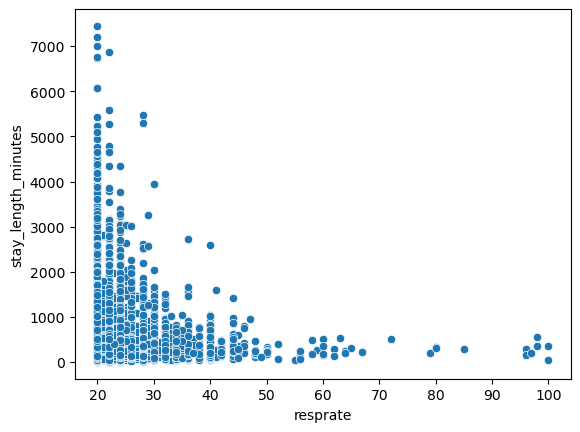

In [19]:
# Resperation rate vs stay length.

sns.scatterplot(x="resprate",
                    y="stay_length_minutes",
                    data=df)

<Axes: xlabel='o2sat', ylabel='stay_length_minutes'>

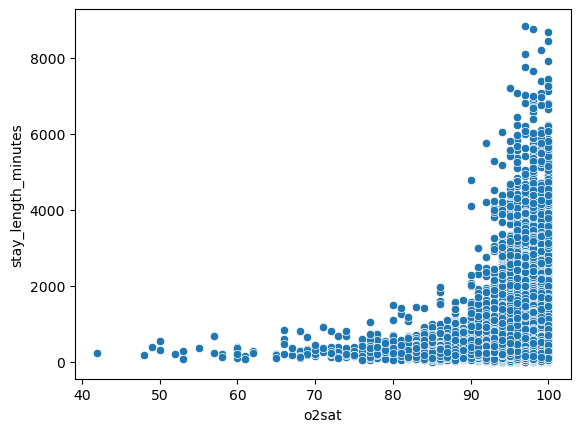

In [20]:
#O2 saturation vs stay length. Note that O2 saturation should normally be near 100%.
sns.scatterplot(x="o2sat",
                    y="stay_length_minutes",
                    data=df)

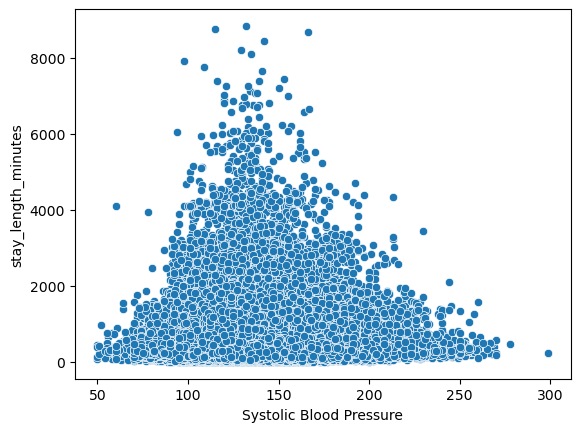

In [44]:
#Systolic blood pressure vs stay length.
sns.scatterplot(x="sbp",
                    y="stay_length_minutes",
                    data=df)
plt.xlabel("Systolic Blood Pressure")
plt.savefig('sbp_stay_length.png', dpi=300) 
plt.show()

<Axes: xlabel='dbp', ylabel='stay_length_minutes'>

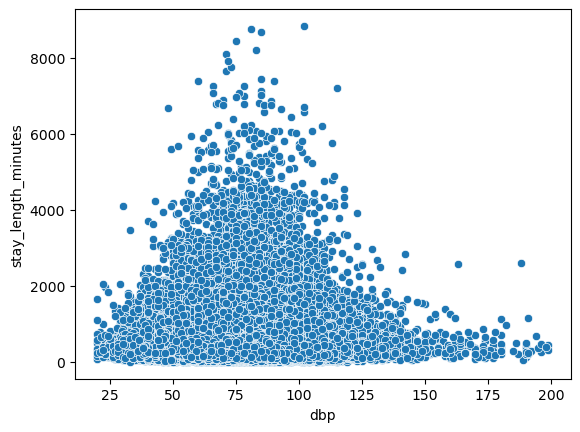

In [22]:
#Stay length vs diastolic blood pressure.

sns.scatterplot(x="dbp",
                    y="stay_length_minutes",
                    data=df)

<Axes: xlabel='admission_age', ylabel='stay_length_minutes'>

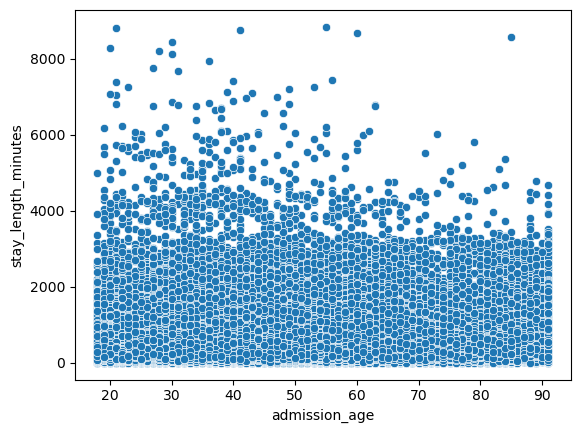

In [23]:
#Admission age vs. stay length.

sns.scatterplot(x="admission_age",
                    y="stay_length_minutes",
                    data=df)

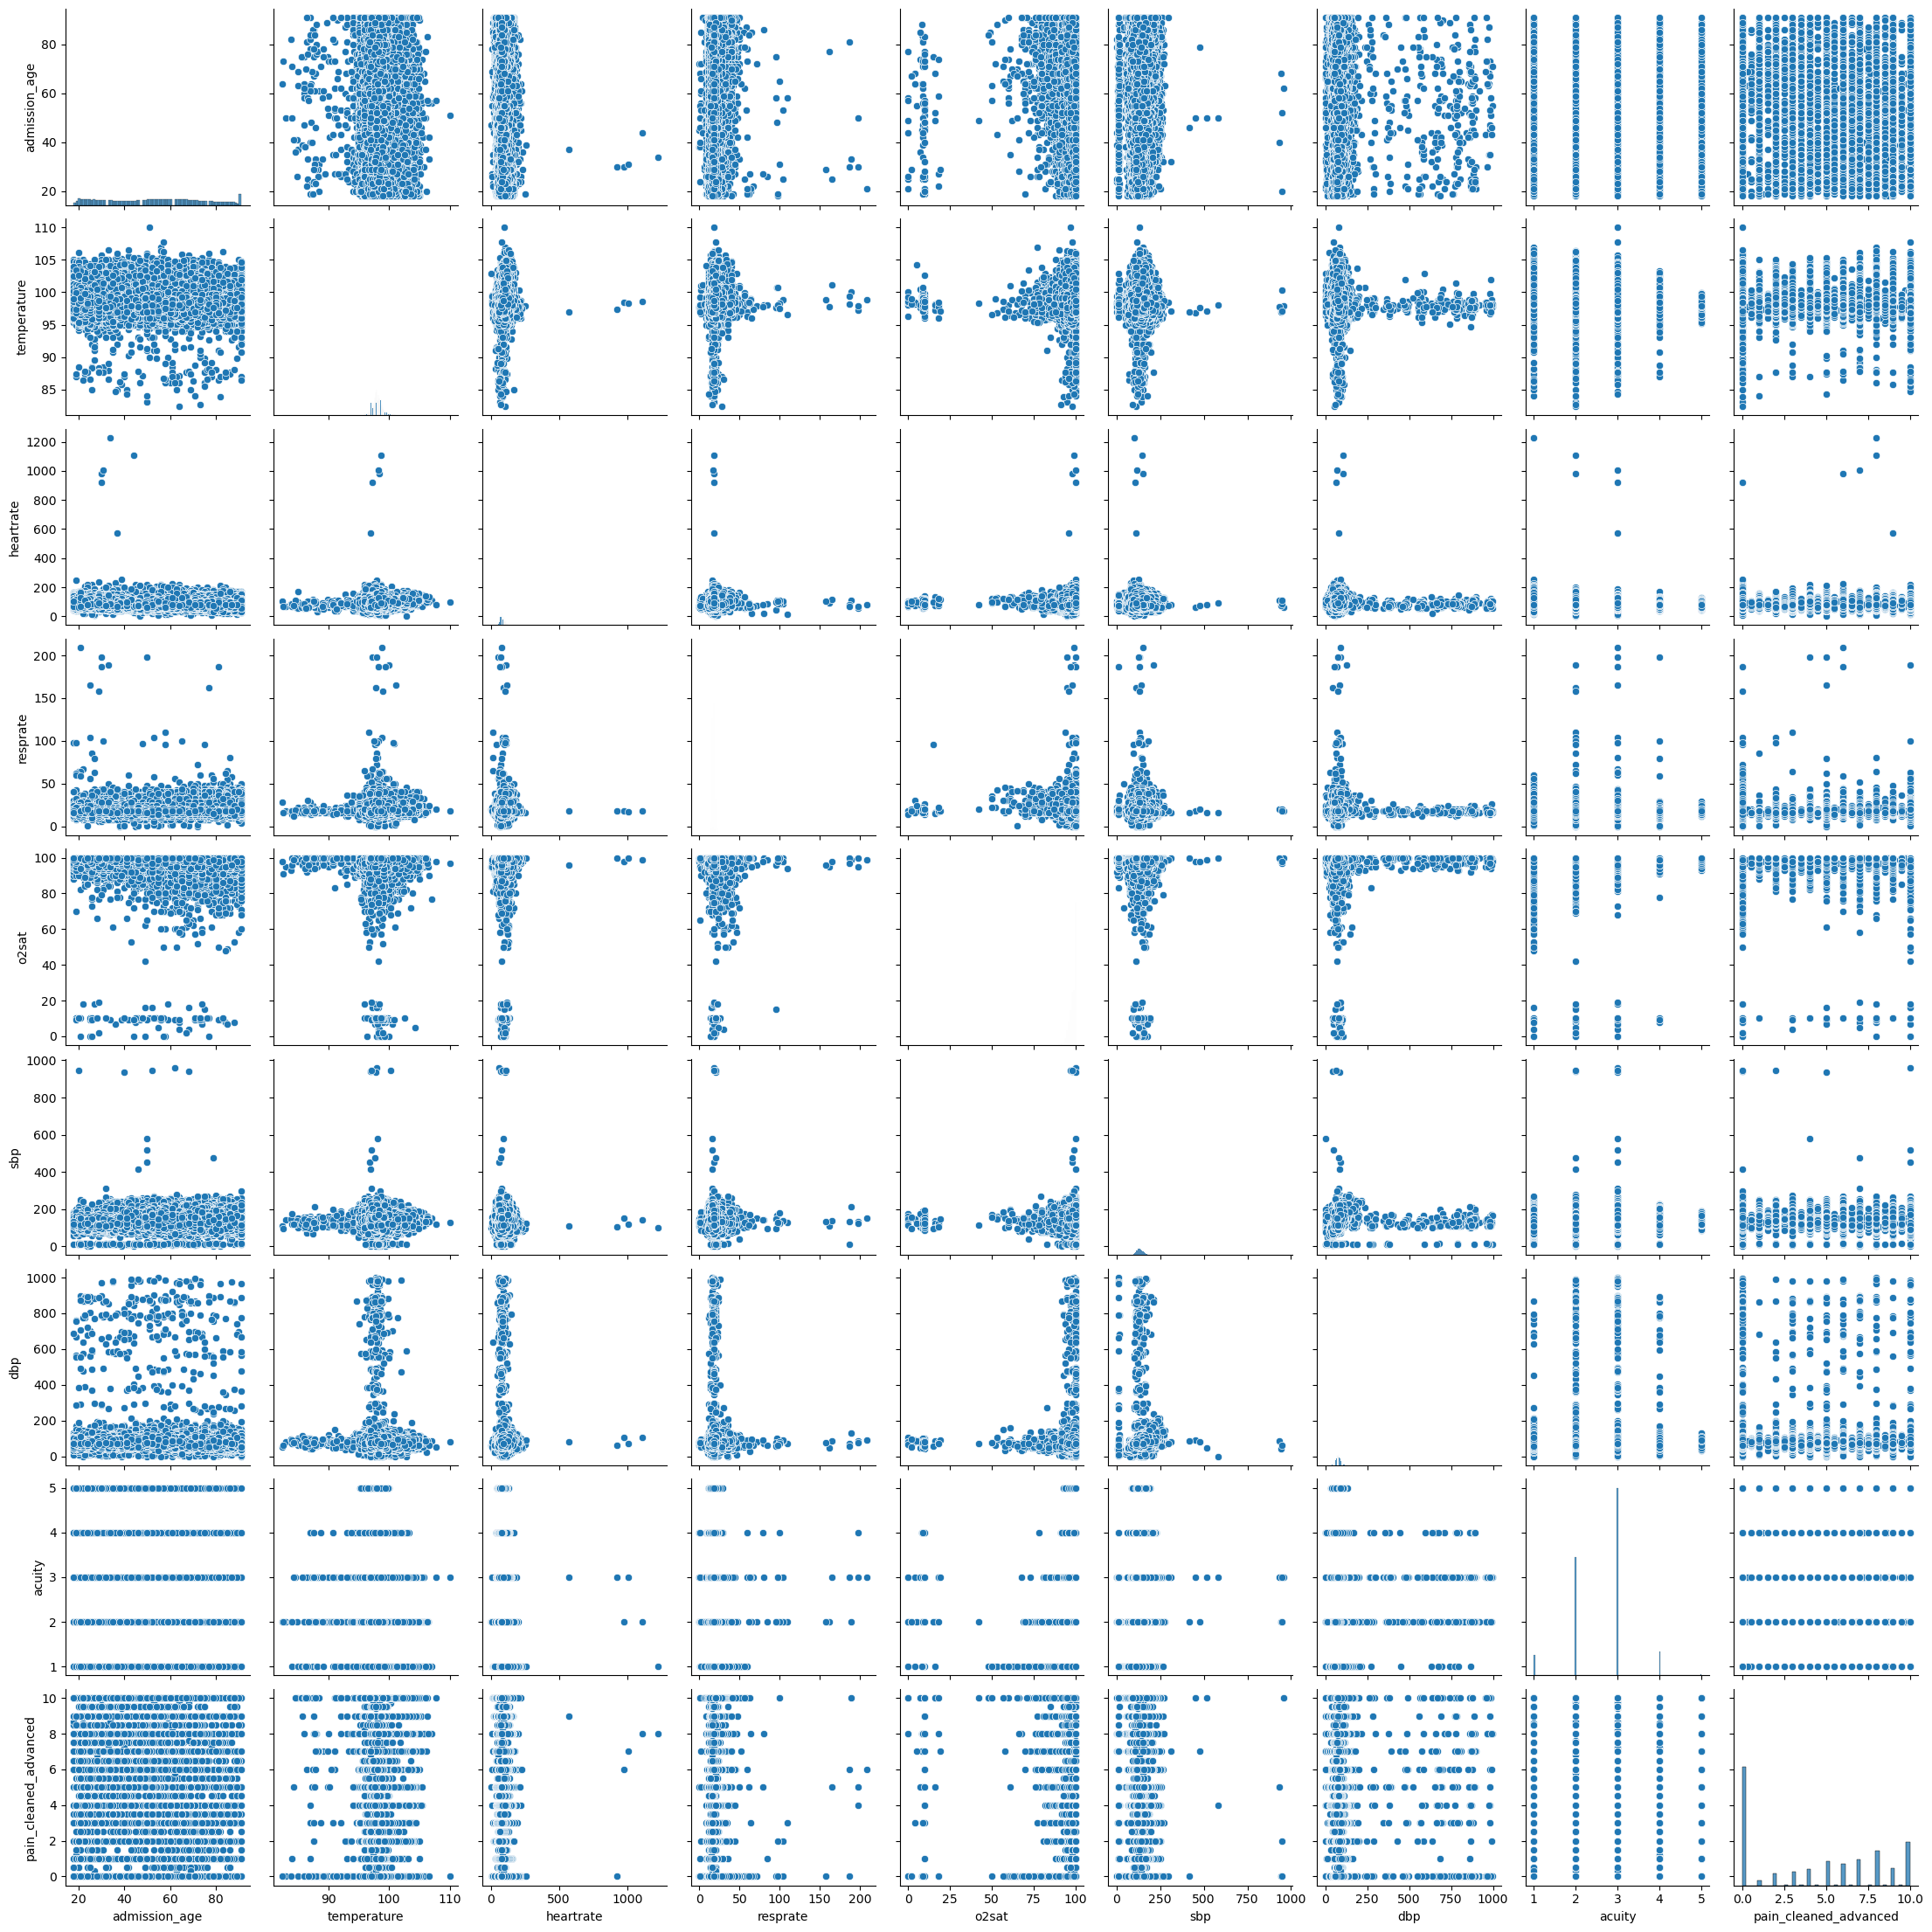

In [ ]:
#A comparison of the various predictor variables to see if there are any relatiohships between them. 
#In general, the variables appear to be inrelated.
quant_features=['admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'pain_cleaned_advanced']
sns.pairplot(df[quant_features])
plt.show()